# Demonstrate differences when using Tensorflow on different CPU types

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Softmax

pd.set_option("display.float_format", '{:.3f}'.format)

In [2]:
def getCPUtype():
    cpuinfo = subprocess.check_output("cat /proc/cpuinfo", shell=True).decode()
    for l in cpuinfo.split("\n"):
        if l.find("vendor_id") >= 0:
            if l.find("GenuineIntel") >= 0:
                return "Intel"
            else:
                return "AMD"

def gen_iterator_rand(mini_batch_size, dataset, labels):
    while True:
        rand_idx = np.random.choice(range(dataset.shape[0]), mini_batch_size, False)
        yield dataset[rand_idx, :], labels[rand_idx].astype('int32')

## Load data

In [3]:
CPUtype = getCPUtype()
print("CPU type:", CPUtype)

train_df = pd.read_csv("training_data.csv", index_col=0)
val_df = pd.read_csv("validation_data.csv", index_col=0)
print("Data shapes:", train_df.shape, val_df.shape)
display(train_df.head())

CPU type: Intel
Data shapes: (902, 30) (221, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,truth
0,0.638,0.742,-0.786,-0.066,2.026,1.200,-1.479,2.081,-0.082,1.192,...,0.958,-1.072,0.665,-0.818,-0.081,1.772,0.305,0.079,0.054,1
1,-0.328,2.127,-1.203,0.365,1.047,3.236,-0.726,0.735,-0.610,2.563,...,-0.101,-1.703,0.092,-0.829,-1.353,1.775,0.952,-1.172,0.456,1
2,1.887,1.355,-0.314,-0.625,0.095,1.003,-0.455,-0.377,0.914,1.550,...,0.324,1.184,0.240,0.871,0.816,0.726,0.417,-0.627,0.084,1
3,1.263,0.843,-1.821,-0.817,1.038,2.108,-1.858,1.079,0.433,2.412,...,-0.932,-1.180,0.974,-1.627,-0.340,1.056,0.378,-2.055,-0.391,1
4,-1.444,1.430,-1.135,-0.930,-0.439,1.631,-1.345,0.005,0.126,-0.787,...,1.266,-1.894,0.494,-1.420,0.029,1.749,1.279,-0.972,1.053,0


## Make model 

In [4]:
tf_seed = 371
batch_size = 128
iteration = 50
hidden_layers = 3
learning_rate = 0.1
hidden_units = 20

# set the various random seeds
np.random.seed(888)
rn.seed(12345)

tf.random.set_seed(tf_seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

initialization = tf.keras.initializers.GlorotUniform(seed=2)

dense_input = tf.keras.Input(shape=(29,), dtype=tf.float32)

a = Dense(
    units=hidden_units,
    activation="relu",
    kernel_initializer=initialization
)(dense_input)

count = 1
for i in range(hidden_layers - 1):
    a = Dense(
        units=hidden_units,
        activation="relu",
        kernel_initializer=initialization
    )(a)
    a = BatchNormalization()(a)

# final layer 
predictions = Dense(
    units=2,
    activation="softmax",
    kernel_initializer=initialization
)(a)

model = Model(inputs=dense_input, outputs=predictions)

adam_opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    name="Adam"
)
model.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', run_eagerly=False)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42    

### Fit model

In [5]:
start_iter=0
np.random.seed(tf_seed)
logfile = open(f"batches_{CPUtype}.log","w")
gen_batch = gen_iterator_rand(batch_size,train_df.drop(["truth"], axis=1).values, 
                                   labels=train_df["truth"].values)
for i in range(start_iter, iteration):
    batch_x, batch_y = next(gen_batch)
    for i,b in enumerate(batch_x):
        logfile.write(repr(i) +" "+ repr(b) +"\n")
    logfile.write("\n")
    #print(batch_x.shape, batch_y.shape)
    model.train_on_batch(batch_x, batch_y)
logfile.close()
val_df["prob_1"] = model.predict(val_df.drop(["truth"], axis=1).values)[:,1]
#display(val_df)
val_df.to_csv(f"val_preds_{CPUtype}.csv")

In [6]:
! diff -s batches_AMD.log batches_Intel.log 

Files batches_AMD.log and batches_Intel.log are identical


### Plot Intel vs. AMD

104   0.117
13    0.107
137   0.103
11    0.079
90    0.055
83    0.052
88    0.048
148   0.047
110   0.044
185   0.040
Name: prob_1, dtype: float64


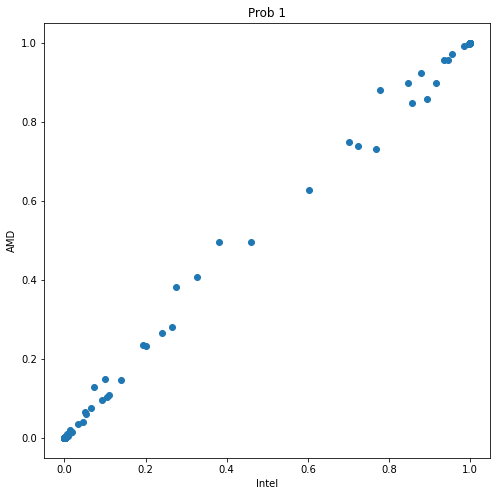

In [7]:
if os.path.exists("val_preds_AMD.csv") and os.path.exists("val_preds_Intel.csv"):
    amd = pd.read_csv("val_preds_AMD.csv")
    intel = pd.read_csv("val_preds_Intel.csv")
    print((intel["prob_1"] - amd["prob_1"]).abs().sort_values(ascending=False).head(10))
    fg = plt.figure(figsize=(8,8))
    plt.scatter(intel["prob_1"], amd["prob_1"])
    plt.title("Prob 1")
    plt.xlabel("Intel")
    plt.ylabel("AMD")
    plt.show()